## Creating the Windy Grid World with King's Moves (diagonal) and Stochastic Wind

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
import numpy as np
from IPython.display import clear_output
%matplotlib inline

class WindyGridWorld:
    def __init__(self, rows=7, cols=10, init_state=30, goal = 37, stochastic=True):
        self.rows = 7
        self.cols = 10
        self.world = np.arange(0,70).reshape((self.rows, self.cols))
        self.stochastic = stochastic
        # Wind
        self.wind = np.zeros((self.rows, self.cols))
        self.wind[:,[3,4,5,8]]=1
        self.wind[:,[6,7]] = 2
        ##
        self.init_state = init_state
        self.state = self.init_state
        self.actions = {0:'right', 1:'left', 2:'up', 3:'down',4:'up_right',5:'up_left', 6:'down_right', 7:'down_left'}
        self.actions_n = len(self.actions)
        self.states_n = rows * cols
        self.goal = goal
    
    def get_state(self,x,y):
        return x*10+y
    
    def coord(self, s):
        return (int(s//10), int(s%10))
    
    def _move(self,s,a):
        X, Y = self.coord(s)
        if a == 0:   # right
            dx, dy = 0,1
        elif a == 1: # left
            dx, dy = 0,-1
        elif a == 2: # up
            dx, dy = -1, 0
        elif a == 3: # down
            dx, dy = 1, 0
        elif a == 4: # up_right
            dx, dy = -1, 1
        elif a == 5: # up_left
            dx, dy = -1, -1
        elif a == 6: # down_right
            dx, dy = 1, 1
        elif a == 7: # down_left
            dx, dy = 1, -1
        wind = self.wind[X,Y]
        stochasticity = np.random.choice([-1,0,1]) if self.stochastic else 0 # Stochastic wind
        dx -= (wind + stochasticity) 
        X += dx
        Y += dy
        if X < 0:
            X=0
        elif X > 6:
            X=6
        if Y<0:
            Y=0
        elif Y>9:
            Y=9
        return self.get_state(X,Y)
    
    def reset(self):
        self.state = self.init_state
    
    def step(self, action):
        """
        :param: action
        Returns: (s',r,done)
        """
        new_state = self._move(self.state, action)
        self.state = new_state
        reward = -1 if new_state != self.goal else 0
        done = False if new_state != self.goal else True
        return new_state,reward,done
    
    def pprint(self, mode="g"):
        world_for_repr = np.copy(self.wind)
        X,Y = self.coord(self.state)
        world_for_repr[X,Y] = 4
        
        if mode=="g":
            plt.imshow(world_for_repr)
            if X == 3 and Y == 7:
                msg = "State: ({},{}) - Won!".format(X,Y)
            else:
                msg = "State: ({},{})".format(X,Y)
            plt.title(msg)
            plt.show()
        elif mode == "t":
            print(world_for_repr)

# Sarsa Agent

In [2]:
class Agent_Sarsa:
    def __init__(self, states_n, actions_n, alpha=0.5, epsilon=0.1, gamma=0.95, epsilon_decay=True, epsilon_decay_factor=0.01):
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.states_n = states_n
        self.actions_n = actions_n
        self.Q = np.zeros((states_n, actions_n))
        self.new_a = None
        self.epsilon_decay = epsilon_decay
        self.epsilon_decay_factor = epsilon_decay_factor
    
    def act(self, state):
        # TODO:epsilon greedy
        if np.random.rand() < self.epsilon:
            act = np.random.choice(np.arange(self.actions_n))
        else:
            act = np.argmax(self.Q[int(state),:])
        return act
    
    def decay_epsilon(self, factor):
        self.epsilon -= factor
    
    def update(self,new_s,r,s,a,done):
        self.new_a = agent.act(new_state)
        mask = 0 if done else 1
        s, a, self.new_a, new_s = int(s), int(a), int(self.new_a), int(new_s)
        self.Q[s,a] += self.alpha * (r + self.gamma * self.Q[new_s, self.new_a]*mask - self.Q[s,a])
        if done and self.epsilon_decay:
            self.decay_epsilon(self.epsilon_decay_factor)
        return self.new_a

# Training an Agent (non-decaying epsilon)

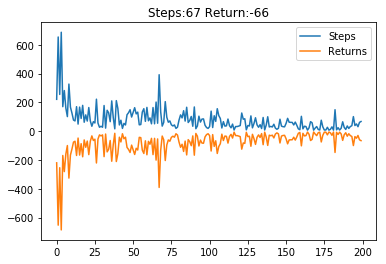

In [3]:
env = WindyGridWorld()
agent = Agent_Sarsa(env.states_n, env.actions_n,epsilon_decay=False)

steps = []
returns = []
for episode in range(200):
    env.reset()
    state = env.state
    action = agent.act(state)
    done = False
    step_n = 0
    return_episode = 0
    while not done:
        new_state,reward,done = env.step(action)
        return_episode += reward
        new_action = agent.update(new_state, reward,state,action,done)
        state, action = new_state, new_action
        step_n += 1
        if done:
            steps.append(step_n)
            returns.append(return_episode)
            clear_output(wait=True)
            plt.title("Steps:" + str(step_n) + " Return:"+str(return_episode))
            plt.plot(list(range(len(steps))),steps)
            plt.plot(list(range(len(steps))),returns)
            plt.legend(["Steps", "Returns"])
            plt.show()

# Watch it After 200 Episodes Training (non-decaying epsilon)
__It still explores.__

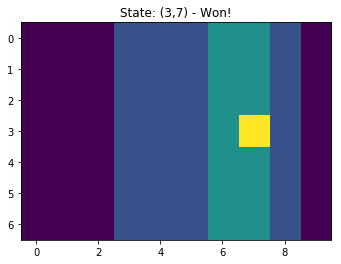

Done in 23 steps.
Actions: [6, 0, 6, 6, 6, 6, 6, 3, 0, 6, 3, 6, 6, 6, 2, 1, 6, 3, 6, 6, 3, 7, 7, 0]
down_right, right, down_right, down_right, down_right, down_right, down_right, down, right, down_right, down, down_right, down_right, down_right, up, left, down_right, down, down_right, down_right, down, down_left, down_left, right, 


In [4]:
for episode in range(3):
    env.reset()
    state = env.state
    action = agent.act(state)
    done = False
    step = 0
    actions = [action]
    while not done:
        new_state,reward,done = env.step(action)
        step += 1
        new_action = agent.update(new_state, reward,state,action,done)
        actions.append(new_action)
        state, action = new_state, new_action
        env.pprint()
        if done:
            print(f"Done in {step} steps.")
            print(f"Actions: {actions}")
            for a in actions:
                print(env.actions[a], end=", ")
            print()
            sleep(3)
        sleep(0.1)
        clear_output(wait=True)

# Training an Agent (decaying epsilon)

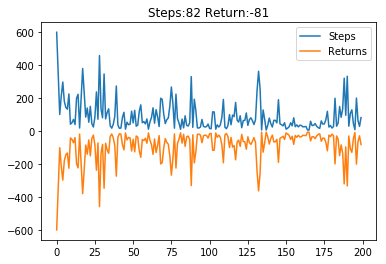

In [5]:
env = WindyGridWorld()
agent = Agent_Sarsa(env.states_n, env.actions_n,epsilon_decay=True)

steps = []
returns = []
for episode in range(200):
    env.reset()
    state = env.state
    action = agent.act(state)
    done = False
    step_n = 0
    return_episode = 0
    while not done:
        new_state,reward,done = env.step(action)
        return_episode += reward
        new_action = agent.update(new_state, reward,state,action,done)
        state, action = new_state, new_action
        step_n += 1
        if done:
            steps.append(step_n)
            returns.append(return_episode)
            clear_output(wait=True)
            plt.title("Steps:" + str(step_n) + " Return:"+str(return_episode))
            plt.plot(list(range(len(steps))),steps)
            plt.plot(list(range(len(steps))),returns)
            plt.legend(["Steps", "Returns"])
            plt.show()

# Watch it After 200 Episodes Training

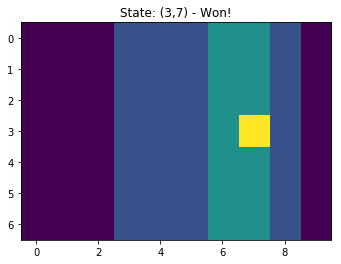

Done in 72 steps.
Actions: [1, 2, 2, 3, 3, 6, 0, 0, 4, 6, 3, 2, 1, 1, 7, 1, 6, 1, 3, 6, 6, 0, 2, 5, 5, 3, 3, 4, 6, 7, 1, 1, 1, 0, 5, 6, 7, 6, 6, 6, 6, 5, 2, 1, 3, 3, 7, 6, 3, 3, 6, 6, 3, 6, 6, 6, 6, 6, 7, 3, 1, 6, 6, 6, 7, 3, 3, 6, 6, 7, 3, 1, 0]
left, up, up, down, down, down_right, right, right, up_right, down_right, down, up, left, left, down_left, left, down_right, left, down, down_right, down_right, right, up, up_left, up_left, down, down, up_right, down_right, down_left, left, left, left, right, up_left, down_right, down_left, down_right, down_right, down_right, down_right, up_left, up, left, down, down, down_left, down_right, down, down, down_right, down_right, down, down_right, down_right, down_right, down_right, down_right, down_left, down, left, down_right, down_right, down_right, down_left, down, down, down_right, down_right, down_left, down, left, right, 


In [6]:
for episode in range(3):
    env.reset()
    state = env.state
    action = agent.act(state)
    done = False
    step = 0
    actions = [action]
    while not done:
        new_state,reward,done = env.step(action)
        step += 1
        new_action = agent.update(new_state, reward,state,action,done)
        actions.append(new_action)
        state, action = new_state, new_action
        env.pprint()
        if done:
            print(f"Done in {step} steps.")
            print(f"Actions: {actions}")
            for a in actions:
                print(env.actions[a], end=", ")
            print()
            sleep(10)
        sleep(0.1)
        clear_output(wait=True)